In [1]:
# dodac opisy funkcji jako docstringi 

In [54]:
# Libraries import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import zipfile
import urllib

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from keras_preprocessing.text import Tokenizer
from matplotlib.pyplot import figure
from numpy import quantile
import scipy.stats as stats

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

ENGLISH_STOP_WORDS = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rkali\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rkali\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rkali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Download the dataset and load it into dataframe
url = 'https://github.com/MWiechmann/enron_spam_data/blob/master/enron_spam_data.zip?raw=true'

urllib.request.urlretrieve(url, 'data.zip')

with zipfile.ZipFile('data.zip', 'r') as zip_ref:
     zip_ref.extractall()

df = pd.read_csv('enron_spam_data.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33716 entries, 0 to 33715
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Message ID  33716 non-null  int64 
 1   Subject     33427 non-null  object
 2   Message     33345 non-null  object
 3   Spam/Ham    33716 non-null  object
 4   Date        33716 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


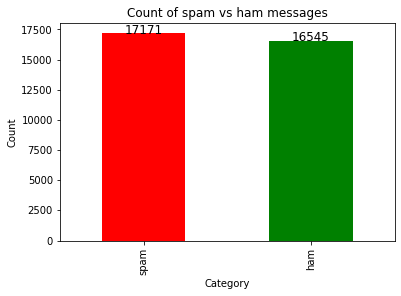

In [8]:
# Count of spam vs ham messages 

counts = df['Spam/Ham'].value_counts()

colors = ['red' if i == 'spam' else 'green' for i in counts.index]

counts.plot(kind = 'bar', color = colors, title = 'Count of spam vs ham messages')
plt.xlabel('Category')
plt.ylabel('Count')

for i, count in enumerate(counts):
    plt.text(i, count, str(count), color = 'black', fontsize = 12, ha = 'center')

plt.show()

In [9]:
# Handling missing values
print(df.isna().sum())

df.dropna(inplace = True)

print(df.isna().sum())

print(df.count())

Message ID      0
Subject       289
Message       371
Spam/Ham        0
Date            0
dtype: int64
Message ID    0
Subject       0
Message       0
Spam/Ham      0
Date          0
dtype: int64
Message ID    33107
Subject       33107
Message       33107
Spam/Ham      33107
Date          33107
dtype: int64


In [21]:
raw_df = df

raw_title = raw_df['Subject'][1]
raw_body = raw_df['Message'][7480]

print(f'Exemplary title before preprocessing: {raw_title}')
print(f'Exemplary e-mail body before preproocessing: {raw_body}')


Exemplary title before preprocessing: vastar resource inc
Exemplary e-mail body before preproocessing: hello vince hear sick hope thank opportunity visit enron speak guy good team wonder come decision regard employment look forward hear regard martin


In [11]:
# Checking on duplicated values

df_grouped = df.groupby(['Spam/Ham', 'Message']).size().reset_index(name = 'Count')
df_grouped[df_grouped['Count'] > 1]

,Spam/Ham,Message,Count
16,ham,' for the record ' questions for the enside ne...,2
60,ham,( see attached file : hplnl 201 . xls )\n- hpl...,2
106,ham,( see attached file : hplno 310 . xls )\n- hpl...,2
107,ham,( see attached file : hplno 313 . xls )\n- hpl...,2
108,ham,( see attached file : hplno 314 . xls )\n- hpl...,2
...,...,...,...
29554,spam,zum\n( fehlgeschlagen ) ? =\ndies ist eine aut...,2
29565,spam,~ welcome to heartwarmers ~\nhttp : / / www . ...,2
29568,spam, best cle course i  ve ever attended ! \nat...,2
29576,spam,µ?? § ? ?? · ?? · ? § ? ? ?? ? ? ? ?? · ???? ¤...,2


In [12]:
# Removing duplicated values and empty e-mails 

df = df.drop_duplicates(subset = ['Message'])
df = df.loc[df['Message'] != '']

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29582 entries, 1 to 33714
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Message ID  29582 non-null  int64 
 1   Subject     29582 non-null  object
 2   Message     29582 non-null  object
 3   Spam/Ham    29582 non-null  object
 4   Date        29582 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.4+ MB


In [13]:
### Text data pre-preocessing

def replace_hyperlink(text):
    pattern = r"http\S+"
    return  re.sub(pattern, "http", text)

def replace_email_address(text):
    pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'
    return re.sub(pattern, "email_address", text)

def to_lower(text):
    result = text.lower()
    return result

def remove_punctuation(text):
    result = text.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(text):
    result = text.strip()
    return result

def remove_duplicated_spaces(text):
    result = " ".join(text.split())
    return result

def replace_newline(text):
    return text.replace('\n',' ')

def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in ENGLISH_STOP_WORDS]
    return " ".join(filtered_words)

def remove_numbers(text):
    tokens = word_tokenize(text)
    tokens_without_numbers = [token for token in tokens if not token.isdigit()]
    return ' '.join(tokens_without_numbers)

def remove_special_characters(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return cleaned_text

def get_wordnet_pos(treebank_tag):
    """Zamienia tagi części mowy z tagsetu Penn Treebank na tagset WordNet"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

lemmatizer = WordNetLemmatizer()
def lemmatize_sentence(sentence):
    tagged_sentence = nltk.pos_tag(nltk.word_tokenize(sentence))
    lemmatized_sentence = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) if get_wordnet_pos(tag) else word for word, tag in tagged_sentence]
    return " ".join(lemmatized_sentence)

def data_cleaning_pipeline(sentence):
    cleaning_utils = [to_lower,
                      replace_hyperlink,
                      replace_email_address,
                      replace_newline,
                      remove_punctuation,
                      remove_special_characters,
                      remove_stop_words,
                      remove_numbers,
                      remove_duplicated_spaces,
                      remove_whitespace,
                      lemmatize_sentence]
    for i in cleaning_utils:
        sentence = i(sentence)
    return sentence

df['Raw_message'] = df['Message']
df['Message'] = [data_cleaning_pipeline(i) for i in df['Message'].astype(str)]
df['Subject'] = [data_cleaning_pipeline(i) for i in df['Subject'].astype(str)]

df.dropna(inplace = True)

#df.to_csv('data_preprocessed.csv', index = False)
#df.to_excel('data_preprocessed.xlsx', index = False)

In [14]:
print(df.isna().sum())
df.dropna(inplace = True)
print(df.isna().sum())

Message ID     0
Subject        0
Message        0
Spam/Ham       0
Date           0
Raw_message    0
dtype: int64
Message ID     0
Subject        0
Message        0
Spam/Ham       0
Date           0
Raw_message    0
dtype: int64


In [22]:
df_title = df['Subject'][1]
df_body = df['Message'][7480]

print(f'Exemplary title after preprocessing: {df_title}')
print(f'Exemplary e-mail body after preproocessing: {df_body}')

Exemplary title after preprocessing: vastar resource inc
Exemplary e-mail body after preproocessing: hello vince hear sick hope thank opportunity visit enron speak guy good team wonder come decision regard employment look forward hear regard martin


In [23]:
# Example of spam and ham e-mails

spam_record = df[df['Spam/Ham'] == 'spam'].iloc[0].Message
print(f"Spam record: {spam_record}")

ham_record = df[df['Spam/Ham'] == 'ham'].iloc[0].Message
print(f"Ham record: {ham_record}")

Spam record: introduce doctor formulate hgh human growth hormone also call hgh refer medical science master hormone plentiful young near age twenty one body begin produce less time forty nearly everyone deficient hgh eighty production normally diminish least advantages hgh increase muscle strength loss body fat increase bone density lower blood pressure quicken wound heal reduces cellulite improve vision wrinkle disappearance increase skin thickness texture increase energy level improve sleep emotional stability improve memory mental alertness increase sexual potency resistance common illness strengthen heart muscle control cholesterol control mood swing new hair growth color restore read website unsubscribe
Ham record: gary production high island large block commence saturday p gross carlos expect gross tomorrow vastar own gross production george x forward george weissman hou ect daren j farmer carlos j rodriguez hou ect ect cc george weissman hou ect ect melissa graf hou ect ect subj

29582


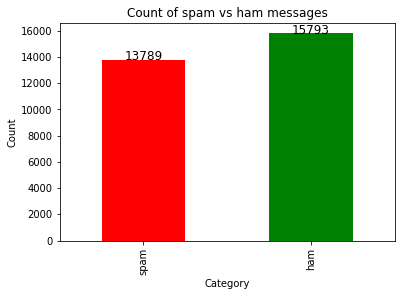

In [24]:
# Count of spam vs ham messages after text preprocessing

counts = df['Spam/Ham'].value_counts()
print(counts.sum())

counts = counts.reindex(['spam', 'ham'])

colors = ['red' if i == 'spam' else 'green' for i in counts.index]

counts.plot(kind = 'bar', color = colors, title = 'Count of spam vs ham messages')
plt.xlabel('Category')
plt.ylabel('Count')

for i, count in enumerate(counts):
    plt.text(i, count, str(count), color = 'black', fontsize = 12, ha = 'center')

plt.show()

In [25]:
# Recoding the 'Spam/Ham' variable into the zero-one variable Spam

df['Spam'] = df['Spam/Ham'].apply(lambda x: 1 if x == 'spam' else 0)
df.head()

,Message ID,Subject,Message,Spam/Ham,Date,Raw_message,Spam
1,1,vastar resource inc,gary production high island large block commen...,ham,1999-12-13,"gary , production from the high island larger ...",0
2,2,calpine daily gas nomination,calpine daily gas nomination doc,ham,1999-12-14,- calpine daily gas nomination 1 . doc,0
3,3,issue,fyi see note already do stella forward stella ...,ham,1999-12-14,fyi - see note below - already done .\nstella\...,0
4,4,meter nov allocation,fyi forward lauri allen hou ect pm kimberly va...,ham,1999-12-14,fyi .\n- - - - - - - - - - - - - - - - - - - -...,0
5,5,mcmullen gas,jackie since inlet river plant shut last day f...,ham,1999-12-14,"jackie ,\nsince the inlet to 3 river plant is ...",0


In [26]:
X = df['Message']
y = df['Spam']

print(X.head())
print(y.head())

1    gary production high island large block commen...
2                     calpine daily gas nomination doc
3    fyi see note already do stella forward stella ...
4    fyi forward lauri allen hou ect pm kimberly va...
5    jackie since inlet river plant shut last day f...
Name: Message, dtype: object
1    0
2    0
3    0
4    0
5    0
Name: Spam, dtype: int64


In [31]:
# Random Forest

max_features = 100 # 500, 1000

vectorizer = TfidfVectorizer(max_features = max_features)

#df.dropna(inplace=True)

X = vectorizer.fit_transform(df.Message)
y = df.Spam

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)


print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

Accuracy: 0.9409577464788732
Precision: 0.9168207024029574
Recall: 0.9603097773475314
F1 score: 0.9380614657210402


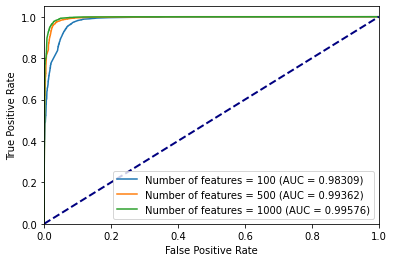

In [36]:
max_features_list = [100, 500, 1000]

for max_features in max_features_list:
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(df.Message)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    rfc = RandomForestClassifier(random_state=1)
    rfc.fit(X_train, y_train)
    
    y_scores = rfc.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label='Number of features = %d (AUC = %0.5f)' % (max_features, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [37]:
# Decision Tree

max_features = 100 #500, 1000

vectorizer = TfidfVectorizer(max_features = max_features)

#df.dropna(inplace=True)

X = vectorizer.fit_transform(df.Message)
y = df.Spam

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

dtc = DecisionTreeClassifier(random_state = 1)
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

print('Accuracy (Decision Tree):', accuracy_score(y_test, y_pred_dtc))
print('Precision (Decision Tree):', precision_score(y_test, y_pred_dtc))
print('Recall (Decision Tree):', recall_score(y_test, y_pred_dtc))
print('F1 score (Decision Tree):', f1_score(y_test, y_pred_dtc))

Accuracy (Decision Tree): 0.9097464788732395
Precision (Decision Tree): 0.8917901670195248
Recall (Decision Tree): 0.9174733785091965
F1 score (Decision Tree): 0.9044494810926876


In [38]:
print(dtc.get_depth())
print(dtc.get_n_leaves())

127
1034


In [39]:
#Cost complexity pruning

path = dtc.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas[::5], path.impurities[::5]

In [41]:
# Finding an optimal value of alpha

clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

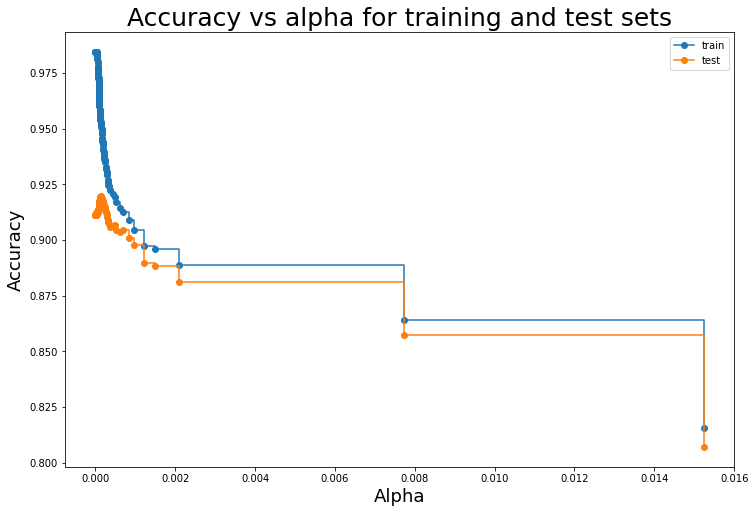

In [42]:
test_scores = [clf.score(X_test,y_test) for clf in clfs]
train_scores = [clf.score(X_train,y_train) for clf in clfs]

fig, ax = plt.subplots(figsize=[12,8])
ax.set_xlabel("Alpha",fontsize=18)
ax.set_ylabel("Accuracy",fontsize=18)
ax.set_title("Accuracy vs alpha for training and test sets",fontsize=25)
ax.plot(ccp_alphas, train_scores, marker='o', label="train",drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",drawstyle="steps-post")
ax.legend()
plt.show()

In [45]:
#Complexity (cost) that produce the best classifcation tree
Best_dtc = clfs[np.argmax(test_scores)]
best_ccp_alpha = Best_dtc.ccp_alpha
print(best_ccp_alpha)

0.00013797956522638999


In [46]:
dtc = DecisionTreeClassifier(random_state = 0, ccp_alpha = best_ccp_alpha)

dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

print('Accuracy (Decision Tree):', accuracy_score(y_test, y_pred_dtc))
print('Precision (Decision Tree):', precision_score(y_test, y_pred_dtc))
print('Recall (Decision Tree):', recall_score(y_test, y_pred_dtc))
print('F1 score (Decision Tree):', f1_score(y_test, y_pred_dtc))

Accuracy (Decision Tree): 0.919661971830986
Precision (Decision Tree): 0.893803271135683
Recall (Decision Tree): 0.9390125847047435
F1 score (Decision Tree): 0.9158503481647585


In [48]:
# Much smaller tree after pruning

print(dtc.get_depth())
print(dtc.get_n_leaves())

53
284


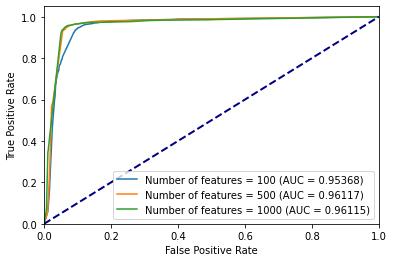

In [50]:
max_features_list = [100, 500, 1000]

for max_features in max_features_list:
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(df.Message)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    dtc = DecisionTreeClassifier(random_state = 1, ccp_alpha = best_ccp_alpha)
    dtc.fit(X_train, y_train)
    
    y_scores = dtc.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label='Number of features = %d (AUC = %0.5f)' % (max_features, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [51]:
# Naive Bayes

max_features = 100 #500, 1000

vectorizer = TfidfVectorizer(max_features = max_features)

df.dropna(inplace=True)

X = vectorizer.fit_transform(df.Message)
y = df.Spam

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)


mnbc = MultinomialNB()
mnbc.fit(X_train, y_train)

y_pred_mnb = mnbc.predict(X_test)

print('Accuracy (Multinomial Naive Bayes):', accuracy_score(y_test, y_pred_mnb))
print('Precision (Multinomial Naive Bayes):', precision_score(y_test, y_pred_mnb))
print('Recall (Multinomial Naive Bayes):', recall_score(y_test, y_pred_mnb))
print('F1 score (Multinomial Naive Bayes):', f1_score(y_test, y_pred_mnb))

Accuracy (Multinomial Naive Bayes): 0.8860845070422535
Precision (Multinomial Naive Bayes): 0.885403803408249
Recall (Multinomial Naive Bayes): 0.8676185866408519
F1 score (Multinomial Naive Bayes): 0.8764209754308765


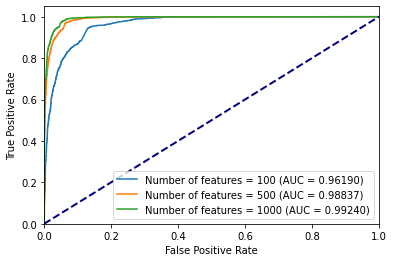

In [52]:
max_features_list = [100, 500, 1000]

for max_features in max_features_list:
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(df.Message)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    
    y_scores = mnb.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label='Number of features = %d (AUC = %0.5f)' % (max_features, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

c:\Users\rkali\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

c:\Users\rkali\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



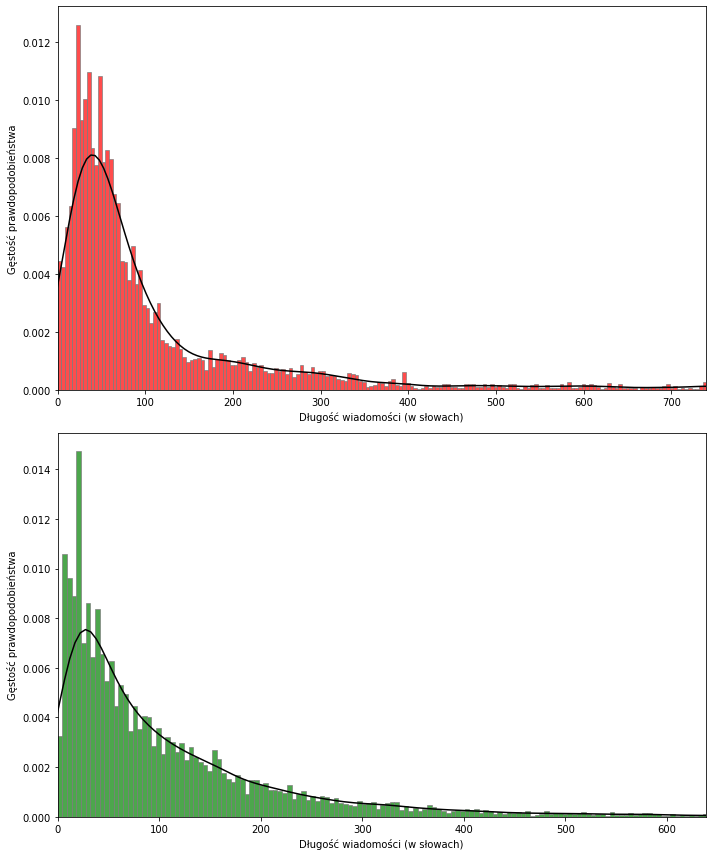

In [58]:
# Message length analysis

vectorizer = TfidfVectorizer(max_features = 100)

spam_messages = df[df['Spam'] == 1]['Message'].dropna()
ham_messages = df[df['Spam'] == 0]['Message'].dropna()

spam_message_lengths = spam_messages.apply(lambda x: len(x.split()))
ham_message_lengths = ham_messages.apply(lambda x: len(x.split()))


spam_message_lengths = spam_message_lengths[spam_message_lengths < quantile(spam_message_lengths, 0.99)]
ham_message_lengths = ham_message_lengths[ham_message_lengths < quantile(ham_message_lengths, 0.99)]

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Histogram for spam messages
sns.distplot(spam_message_lengths, color='red', kde=True, kde_kws={'color': 'black'}, hist_kws={'edgecolor': 'grey', 'alpha': 0.7}, bins=200, ax=axes[0])
axes[0].set_xlabel('Długość wiadomości (w słowach)')
axes[0].set_ylabel('Gęstość prawdopodobieństwa')
axes[0].set_xlim(0, quantile(spam_message_lengths, 0.99))  

# Histogram for ham messages
sns.distplot(ham_message_lengths, color='green', kde=True, kde_kws={'color': 'black'}, hist_kws={'edgecolor': 'grey', 'alpha': 0.7}, bins=200, ax=axes[1])
axes[1].set_xlabel('Długość wiadomości (w słowach)')
axes[1].set_ylabel('Gęstość prawdopodobieństwa')
axes[1].set_xlim(0, quantile(ham_message_lengths, 0.99))  

plt.tight_layout()
plt.show()

In [64]:
# Perform t-test
t_statistic, p_value_ttest = stats.ttest_ind(spam_message_lengths, ham_message_lengths)
print("T-Test:")
print("T-statistic:", t_statistic)
print("P-value:", p_value_ttest) # we do not reject the null hypothesis

# Perform U-test
u_statistic, p_value_uwtest = stats.mannwhitneyu(spam_message_lengths, ham_message_lengths, alternative='two-sided')
print("U-Mann-Whitney Test:")
print("U-statistic:", u_statistic)
print("P-value:", p_value_uwtest) # we do not reject the null hypothesis

T-Test:
T-statistic: 1.1506570785555807
P-value: 0.2498827365047377
U-Mann-Whitney Test:
U-statistic: 105995853.5
P-value: 0.3178999919821355


c:\Users\rkali\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


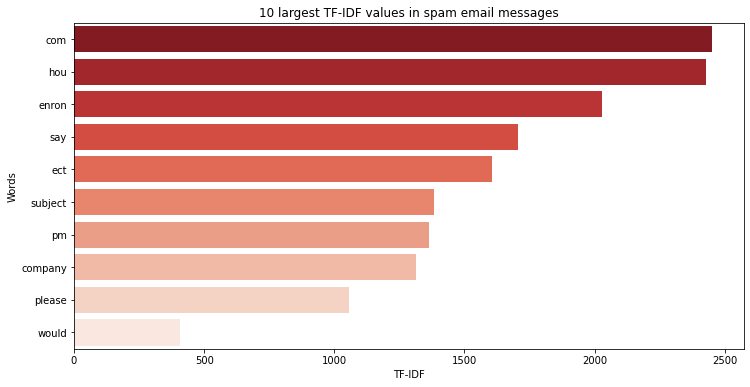

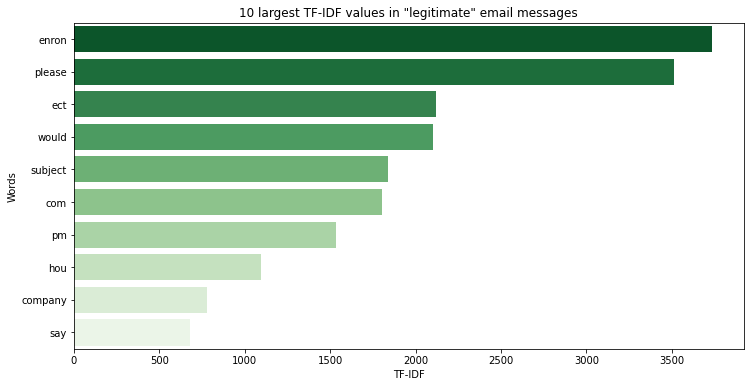

In [65]:
# TF-IDF analysis 

vectorizer = TfidfVectorizer(max_features=10)

spam_messages = df[df['Spam'] == 1 ]['Message'].dropna()
ham_messages = df[df['Spam'] == 0]['Message'].dropna()

tfidf_spam = vectorizer.fit_transform(spam_messages)
tfidf_ham = vectorizer.fit_transform(ham_messages)

# Get the feature names (words in the vocabulary)
feature_names = vectorizer.get_feature_names()

# Calculate the TF-IDF values
tfidf_spam_values = tfidf_spam.toarray().sum(axis=0)
tfidf_ham_values = tfidf_ham.toarray().sum(axis=0)

top_n = 10

# Bar chart for spam messages
spam_tfidf_freq = pd.DataFrame(tfidf_spam_values, index=feature_names, columns=['TF-IDF']).sort_values(by='TF-IDF', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=spam_tfidf_freq['TF-IDF'][:top_n].values, y=spam_tfidf_freq.index[:top_n], palette='Reds_r')
plt.title('{} largest TF-IDF values in spam email messages'.format(top_n))
plt.xlabel('TF-IDF')
plt.ylabel('Words')
plt.show()

# Bar chart for ham messages
ham_tfidf_freq = pd.DataFrame(tfidf_ham_values, index=feature_names, columns=['TF-IDF']).sort_values(by='TF-IDF', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=ham_tfidf_freq['TF-IDF'][:top_n].values, y=ham_tfidf_freq.index[:top_n], palette='Greens_r')
plt.title('{} largest TF-IDF values in "legitimate" email messages'.format(top_n))
plt.xlabel('TF-IDF')
plt.ylabel('Words')
plt.show()